# 1. Business understanding

Listing any type of property in AirBnb has become an important source of income for many owners, and also is an affordable acommodation option for travelers in a budget (although you can also find [castles](https://www.airbnb.com.co/rooms/9859896?_set_bev_on_new_domain=1614045046_YWZlODRlMTIwNzZi&source_impression_id=p3_1614045065_a6TPR4xPl0MoDwRs&guests=1&adults=1) and [islands](https://www.airbnb.com.co/rooms/1296802?_set_bev_on_new_domain=1614045046_YWZlODRlMTIwNzZi&source_impression_id=p3_1614045210_eUMTMwo0wunP4gz1))


## Boston?

The real reason behind the selection of Boston as an Airbnb study case is purely based in the Udacity Nanodregree recomendation, but there are some interesting fats surrounding the listings in this city.

- A 2016 study suggested that a 10% increase in Airbnb listings led to a 0.42% increase in rent prices being asked in that area. [fact 1](https://ipropertymanagement.com/research/airbnb-statistics)
- Boston is the 12th highest occupancy rate city in the U.S. [fact 2](https://www.stratosjets.com/blog/airbnb-statistics/)
- "...The new rules require that hosts own the properties they rent out, and live in them for at least nine months of the year." [fact 3](https://www.cnbc.com/2019/12/03/in-boston-airbnb-tasked-with-removing-thousands-of-illegal-listings.html)


## What data do we have?

The dataset has three archives to work with: 

- ***Listings***, including full descriptions and average review score
- ***Reviews***, including unique id for each reviewer and detailed comments

## What question do we want to answer?

1. Is there is a strong correlation between the size of the listing and its price?
2. Is Location the most important variable for demand and pricing?
3. Past reviews impact future listings of the place?

# 2. Data Understanding

##  Environment and data

First af all, lets load all needed packages and teh data we will be working with.

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from sklearn import preprocessing

df_lis = pd.read_csv('./listings.csv')
df_rev = pd.read_csv('./reviews.csv')

## Listings!

This dataset contais full descriptions of the listings and average review score



In [3]:
df_lis.shape

(3585, 95)

The datased has 95 variables for 3858 listings. It holds some interesting nonstructured data, like **summary**, **space** and **descripcion**. Although this variables surely have relevant information for the desition of the traveler, we will be focusing our efforts in understanding how numeric and categorical variables influence price. With this in mind we are going to be working with the columns selected in the next cell.

In [4]:
df_lis=df_lis[['id','host_since', 'host_response_rate','host_acceptance_rate',
                'host_is_superhost','host_total_listings_count','latitude',
                'longitude','property_type','room_type','accommodates',
                'bathrooms','bedrooms','price', 'number_of_reviews', 
                'review_scores_rating','review_scores_accuracy',
                'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                'review_scores_location','review_scores_value','instant_bookable']]

### Lets do some EDA over Listings

Lets beging diferentiationg numeric and categorical variables

In [5]:
df_lis.dtypes

id                               int64
host_since                      object
host_response_rate              object
host_acceptance_rate            object
host_is_superhost               object
host_total_listings_count        int64
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
price                           object
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
instant_bookable                object
dtype: object

It seems we have some issues with the two variables 'price' and 'security_deposit'. We have to change the type to float but doing some replacements first.

In [6]:
df_lis['price'] = df_lis['price'].str.replace('$', '')
df_lis['price'] = df_lis['price'].str.replace(',', '')
df_lis['price']=df_lis['price'].astype('float')

df_lis['host_acceptance_rate'] = df_lis['host_acceptance_rate'].str.replace('%', '')
df_lis['host_acceptance_rate']=df_lis['host_acceptance_rate'].astype('float')

In [7]:
# Here we split numeric and categorical variables in two datasets
l_num_vars = df_lis[df_lis.select_dtypes(include=['float', 'int']).columns]
l_cat_vars = df_lis[df_lis.select_dtypes(include=['object']).columns]

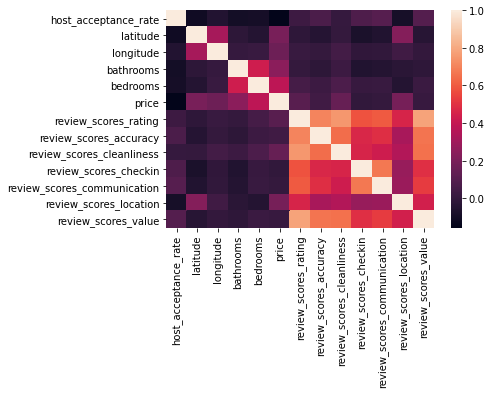

In [8]:
#Now lets plot some correlations
sns.heatmap(l_num_vars.corr())
plt.show()

There seem to be some obvoius correlations:

1. The scores have the biggest correlation between them.
2. Between the number of bedrooms and the number of bed.

But there are some that are not that simple:

1. It seems that the socre that are more correlate with price are location and cleanliness
2. Latitude seems to be more correlated with price that longitude

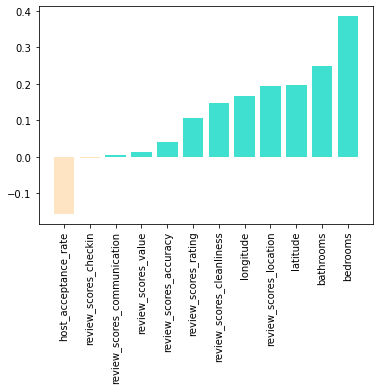

In [9]:
corr_lis=l_num_vars.corr().stack().reset_index()
corr_lis.columns = ['var_1','var_2','corr']
price_corr=corr_lis[corr_lis['var_1']=='price'].sort_values(by=['corr'])  
price_corr=price_corr[price_corr['var_2']!='price']

x = price_corr['var_2']
y = price_corr['corr']

mask1 = y < 0
mask2 = y >= 0

plt.xticks(rotation = 90)
plt.bar(x[mask1], y[mask1], color = 'bisque')
plt.bar(x[mask2], y[mask2], color = 'turquoise')
plt.show()

 Checking correlations only with 'price' it is clear that the number of bedrooms/beds, therefore the size of the listing, is strongly correlated with the price. Location (latitude and longitude) have a some correlation with price.

## Reviews!

This dataset has unique id for each reviewer and detailed comments



In [10]:
df_rev.shape

(68275, 6)

In [11]:
df_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [12]:
df_rev=df_rev.drop(['id','date','reviewer_name'],axis=1)

In [13]:
df_rev.groupby(['listing_id']).count().sort_values(by=['comments'],ascending=False).head()

,reviewer_id,comments
listing_id,,
66288,404,402
1497879,320,320
414419,312,312
31796,291,290
815639,281,281


Some listing have up to 402 comments!

In [14]:
df_rev.groupby(['reviewer_id']).count().sort_values(by=['comments'],ascending=False).head()

,listing_id,comments
reviewer_id,,
12096536,37,37
40651868,25,25
46024609,22,22
52667131,21,21
39441871,18,18


How much traveling does it takes to visit 37 different listing!

This dataset is pretty straight forward. In the following section we are going to try and use some sort of prebuilt sentiment analisys tool so we can clasify the comments and try to predict the price :)

# 3. Data Preparation

In this section we are going to get our databases ready for modeling, doing some data cleaning, transformation and imputation

## Reviews!

The following list shows the transformation to be made in each of the columns in this dataset

**price:** apply logarithm and Normalization 

1. **host_since:** Calculate the monts this host hase been related to Airbnb and Normalization
2 **host_response_time:** Dummify
3. **host_response_rate:** Normalization
4. **host_acceptance_rate:** Normalization
5. **host_is_superhost:** Dummify
6. **host_total_listings_count:** Normalization
7. **latitude:** Normalization
8. **longitude:** Normalization
9. **property_type:** Dummify
10. **room_type:** Dummify
11. **accommodates:** Normalization
12. **bathrooms:** Normalization
13. **bedrooms:** Normalization
14.**beds:** Normalization
15.**price:** Normalization
16.**guests_included:** Normalization
17. **number_of_reviews:** Normalization
18. **review_scores_rating:** Normalization
19. **review_scores_accuracy:** Normalization
20. **review_scores_cleanliness:** Normalization
21. **review_scores_checkin:** Normalization
22. **review_scores_communication:** Normalization
23. **review_scores_location:** Normalization
24. **review_scores_value:** Normalization
25. **instant_bookable:** Dummify

But first, we are going to perform some type changes an calculations in some variables

In [15]:
#Here we are calculating the number of months between the most recent host and all the others

df_lis.host_since=pd.to_datetime(df_lis.host_since)
df_lis.host_since=(max(df_lis.host_since)-df_lis.host_since)
df_lis.host_since=(df_lis.host_since/ np.timedelta64(1, 'D')).astype(float)/30

In [16]:
#Here we change the type of the percentage.

df_lis.host_response_rate = df_lis.host_response_rate.str.replace('%', '')
df_lis.host_response_rate = df_lis.host_response_rate.astype(float)

Before normalizing an getting the dummy variables for the categories, we are going to apply some prebuilt sentiment analyzer on the reviwes. We are going to use NLTK prebuilt sentyment analyzer.

In [17]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
def get_pos(comment):
    '''
    INPUT
    comment - string 
    OUTPUT
    Positive score of Nltk sentimen analyzer.
    '''
    sia = SentimentIntensityAnalyzer()
    pos=sia.polarity_scores(comment).get('pos')
    return pos
    

In [19]:
#Now we are going to apply our funtion to every coment, and average the value by listing id

df_rev.comments = df_rev.comments.astype('str') 
df_rev['positive']=df_rev.comments.apply(get_pos)
df_rev_mean=df_rev.groupby('listing_id')['positive'].mean().to_frame()

## Joining Resulting Dataframes


In [20]:
df_lis=df_lis.set_index('id')
mergedDf = df_lis.merge(df_rev_mean, left_index=True, right_index=True)

This following function is based on the one showd in the solution of some quizes in Udacitys nanodegree.

# Something missing?

We are going to handle missin values in three ways:

1. Price: this is our lable, so we are going to drop all null values.
2. Numeric variables: The numeric values are going to be filled with the mean. 
3. Categorical variables: In this case the absence of variable in the dummies captures the null values.

This is safe for our model, becaouse there woulfd be no considerable variance for the inputed variables.


In [21]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    5. For each numeric variable in X, perform min max normalization
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing price values
    df = df.dropna(subset=['price'], axis=0)
    y = df['price']
    y = np.log(y)
    y = (y-min(y))/(max(y)-min(y))


    #Drop price columns
    df = df.drop(['price'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        df[col]=(df[col]-min(df[col]))/(max(df[col])-min(df[col]))
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y

In [31]:
mergedDf.shape

(2829, 23)

In [24]:
X, y = clean_data(mergedDf)  

In [315]:
X.head()

,host_since,host_response_rate,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,number_of_reviews,...,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Private room,room_type_Shared room,instant_bookable_t
3075044,0.542456,1.0,1.00,1,0.326532,0.216461,2,0.166667,0.2,36,...,0,0,0,0,0,0,0,1,0,1
6976,0.936491,1.0,0.88,1,0.366763,0.208342,2,0.166667,0.2,41,...,0,0,0,0,0,0,0,1,0,0
1436513,0.430877,1.0,0.50,1,0.293199,0.294379,4,0.166667,0.2,1,...,0,0,1,0,0,0,0,1,0,0
7651065,0.295789,1.0,1.00,1,0.315311,0.205466,2,0.250000,0.2,29,...,0,0,1,0,0,0,0,1,0,0
12386020,0.056491,1.0,0.95,2,0.361906,0.230939,2,0.166667,0.2,8,...,0,0,0,0,0,0,0,1,0,0


In [316]:
y.head()

3075044     0.372257
6976        0.372257
1436513     0.402243
7651065     0.413131
12386020    0.402243
Name: price, dtype: float64

Now we have the datasets ready to model

# 4. Modeling

In this section we are going to use a simple random forest to predict the price of the listings. We are going be doing the following steps:

1. Split data
2. Instantiate model and fit
4. Evaluate

## Split data

The data will bi splitted 80/20 for train and test



In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [318]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2263, 33)
Training Labels Shape: (2263,)
Testing Features Shape: (566, 33)
Testing Labels Shape: (566,)


## Instantiate and fit model

We are going to use a simple Random forest with 1000 estimators.



In [320]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 321)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=321)

## Evaluate Model

Since we did some transformations to the lable (price) for the error meassure to make sense we have to reverse this transormations to our predictions and test labels.



In [321]:
pred = rf.predict(X_test)

In [322]:
def deform(t_price):
    '''
    INPUT
    t_price - price with log and min/max transformation 
    OUTPUT
    price in USD.
    '''
    min_y=min(np.log(mergedDf.price))
    max_y=max(np.log(mergedDf.price))

    t_price= t_price*(max_y-min_y) + min_y
    t_price= np.exp(t_price)


    return t_price
    

In [323]:
pred_usd= deform(pred)
y_test_usd= deform(y_test)

In [324]:
errors = abs(pred_usd - y_test_usd)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'USD.')

Mean Absolute Error: 38.43 USD.


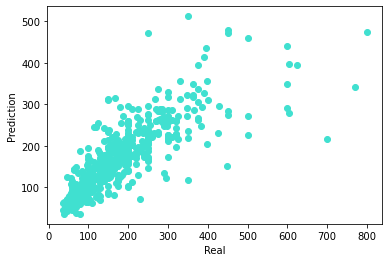

In [334]:
ax = plt.gca()
ax.scatter(y_test_usd, pred_usd, color="turquoise")
plt.xlabel("Real")
plt.ylabel("Prediction");

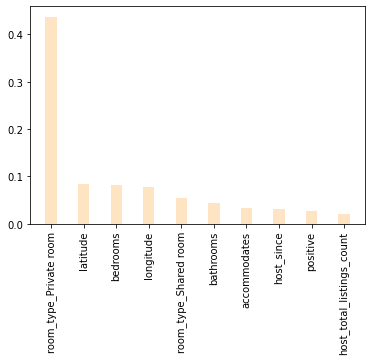

In [330]:
importances = list(rf.feature_importances_)
labels = X.columns.tolist()
df_imp=pd.DataFrame({'variable': labels,'imp': importances})
df_most=df_imp.sort_values(by=['imp'],ascending=False).head(10)

#Plot with importances
fig, ax = plt.subplots()
ax.bar(df_most.variable, df_most.imp, 0.35, color='bisque')
plt.xticks(rotation=90)
plt.show()



# 5. Results, Evaluation and Insights

Regarding our initial questions we have the following:

1. Is there is a strong correlation between the size of the listing and its price?

If we consider the correlation between the number of bathrooms and how many people a listing can accommodate with size, the short answer is yes. 

2. Is Location the most important variable for demand and pricing?

Location (captured by lat and lon) is one of the most important variables to consider when we are taliing about he price of the listing. It is quite obvious locaiton will be important, but its kind of interseting finding that latitude is more important than longitud, meaning that its more relevant deciding wether to invest in real state north/south than east/west.

3. Past reviews impact future listings of the place?

The actual reviw score did not show up as one of the main variables, althoug the variable 'positive' (wich captures the sentiment of the comments) has some impact on the pricing.


## Conclusion

Wraping up, we found that there is a strong correlation between the location of a listing and its price (kind of obvious), but th real insight here is that the average sentimen of the comments is way more important than the socres given by the guests.